In [202]:
#import standard data analysis libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

In [203]:
import warnings
warnings.filterwarnings('ignore')

This part of the code contains the functions used later on

In [205]:
def compute_player_pa_and_bf(df_players, at_bat_ids, df_savant):
    """
    Computes and adds key baseball statistics for batters and pitchers, including:
    - Total plate appearances (PA) per batter per year.
    - Total batters faced (BF) per pitcher per year.
    - Number of times a base-running event ended an inning.

    The function modifies df_players by merging these computed statistics.

    Parameters:
    -----------
    df_players : pandas.DataFrame
        DataFrame containing player information, including player IDs and years.
    at_bat_ids : pandas.DataFrame
        DataFrame containing at-bat events with batter, pitcher, and year identifiers.
    df_savant : pandas.DataFrame
        Baseball Savant dataset containing detailed play-by-play event data.

    Returns:
    --------
    pandas.DataFrame
        Updated df_players with the following new columns:
        - 'total_pa': Total plate appearances per batter per year.
        - 'total_bf': Total batters faced per pitcher per year.
        - 'base_ended_inn': Count of plate appearances ending due to pickoffs or caught stealing.
    
    Notes:
    ------
    - The function ensures missing values are filled with 0 before merging.
    - Plate appearances that ended due to certain basepath outs (e.g., pickoffs, caught stealing)
      with two outs are subtracted from the total plate appearances.
    """

    # Count total plate appearances for each batter per year
    pa_counts = at_bat_ids.groupby(['batter', 'year'])['at_bat_id'].nunique().reset_index(name='total_pa')
    df_players = df_players.merge(pa_counts, left_on=['player_mlb_id', 'year'], right_on=['batter', 'year'], how='left').drop(columns='batter')
    df_players['total_pa'] = df_players['total_pa'].fillna(0).astype(int)

    # Count total batters faced for each pitcher per year
    bf_counts = at_bat_ids.groupby(['pitcher', 'year'])['at_bat_id'].nunique().reset_index(name='total_bf')
    df_players = df_players.merge(bf_counts, left_on=['player_mlb_id', 'year'], right_on=['pitcher', 'year'], how='left').drop(columns='pitcher')
    df_players['total_bf'] = df_players['total_bf'].fillna(0).astype(int)
    
    # Define basepath outs that result in an out
    basepath_outs = [
        'caught_stealing_3b', 'caught_stealing_2b', 'pickoff_caught_stealing_2b', 'pickoff_2b',
        'pickoff_caught_stealing_3b', 'pickoff_1b', 'caught_stealing_home', 'pickoff_3b', 'pickoff_caught_stealing_home'
    ]

    # Filter for basepath events that ended an inning (2 outs when the event occurred)
    df_basepath_ends_inning = df_savant[(df_savant['outs_when_up'] == 2) & (df_savant['events'].isin(basepath_outs))]
    count_basepath_ended_ab = df_basepath_ends_inning.groupby(['batter', 'year'])['at_bat_id'].nunique().reset_index(name='base_ended_inn')

    # Merge basepath-ended inning counts and adjust plate appearances
    df_players = df_players.merge(count_basepath_ended_ab, left_on=['player_mlb_id', 'year'], right_on=['batter', 'year'], how='left').drop(columns='batter')
    df_players['base_ended_inn'] = df_players['base_ended_inn'].fillna(0).astype(int)
    df_players['total_pa'] = df_players['total_pa'] - df_players['base_ended_inn']

    return df_players


In [206]:
def get_fielding_counts(df_players, df_savant):
    """
    Computes and adds fielding appearance counts for each player at every defensive position per year.

    This function extracts fielding data from the Baseball Savant dataset, counts the number of 
    at-bats where a player appeared at each position, and merges these counts into the player dataset.

    Parameters:
    -----------
    df_players : pandas.DataFrame
        DataFrame containing player information, including player IDs and years.
    df_savant : pandas.DataFrame
        Baseball Savant dataset containing at-bat-level fielding data.

    Returns:
    --------
    pandas.DataFrame
        Updated df_players with additional columns representing the number of fielding appearances 
        at each defensive position per year. New columns follow the format:
        - 'field_p'  : Appearances as a pitcher
        - 'field_c'  : Appearances as a catcher
        - 'field_1b' : Appearances as a first baseman
        - 'field_2b' : Appearances as a second baseman
        - 'field_3b' : Appearances as a third baseman
        - 'field_ss' : Appearances as a shortstop
        - 'field_lf' : Appearances as a left fielder
        - 'field_cf' : Appearances as a center fielder
        - 'field_rf' : Appearances as a right fielder
    """
    
    #get the fielders for every at bat
    df_savant_fielding = df_savant[['at_bat_id','year','pitcher_1',
        'fielder_2_1', 'fielder_3', 'fielder_4', 'fielder_5', 'fielder_6',
        'fielder_7', 'fielder_8', 'fielder_9']].drop_duplicates()

    #list of each position column name
    fielding_columns = ['pitcher_1', 'fielder_2_1', 'fielder_3', 
                        'fielder_4', 'fielder_5', 'fielder_6',
                        'fielder_7', 'fielder_8', 'fielder_9']
    
    #dictionary to change position column to more recognizable name
    fielding_dict = {'pitcher_1':'p', 'fielder_2_1':'c', 'fielder_3':'1b', 
                     'fielder_4':'2b', 'fielder_5':'3b', 'fielder_6':'ss',
                     'fielder_7':'lf', 'fielder_8':'cf', 'fielder_9':'rf'}
    
    #get count for every player at every position
    for col in fielding_columns:
        col_name = 'field_' + fielding_dict[col]
        count_df = df_savant_fielding.groupby([col, 'year']).size().reset_index(name=col_name)
        
        #add count to main dataframe
        df_players = df_players.merge(count_df, how='left', left_on=['player_mlb_id', 'year'], right_on=[col, 'year']).drop(columns=col)
        
        #fill NaN with 0
        df_players[col_name] = df_players[col_name].fillna(0).astype(int)

    return df_players

In [207]:
def get_count_for_play_event(df_player, df_sav, col_name, event, player_type):
    """
    Computes the number of occurrences of a specific baseball event for each player in a given year 
    and adds the count as a new column to the player dataframe.

    Parameters:
    -----------
    df_player : pandas.DataFrame
        DataFrame containing player information, including player IDs and years.
    df_sav : pandas.DataFrame
        Baseball Savant dataset containing event details.
    event : str
        The specific event to count (e.g., 'home_run', 'strikeout').
    player_type : str
        Specifies whether to filter data by 'batter' or 'pitcher' statistics.

    Returns:
    --------
    pandas.DataFrame
        The input df_player with an additional column representing the count of the specified event 
        for each player per year.
    """
    
    #filter to specified event
    df_filter = df_sav[df_sav[col_name] == event]

    #get event count for every batter/year combo
    col_name = player_type + '_' + event
    count_df = df_filter.groupby([player_type, 'year']).size().reset_index(name=col_name)

    #add column to main dataframe
    df_player = df_player.merge(count_df, how='left', left_on=['player_mlb_id', 'year'], right_on=[player_type, 'year']).drop(columns=player_type)
    df_player[col_name] = df_player[col_name].fillna(0).astype(int)

    return df_player

    #df_players = df_players.merge(count_df, how='left', left_on=['player_mlb_id', 'year'], right_on=[col, 'year']).drop(columns=col)

    

In [208]:
def calculate_batters_faced_in_game(df_players,df_savant):
    df_bf_per_app = df_savant.groupby(['pitcher', 'year','at_bat_id'])['pitcher_at_bat_number'].max().reset_index().groupby(['pitcher', 'year'])['pitcher_at_bat_number'].mean().reset_index(name='avg_bf_per_outing')
    df_players = df_players.merge(df_bf_per_app, how='left', left_on=['player_mlb_id', 'year'], right_on=['pitcher', 'year']).drop(columns='pitcher')
    return df_players

In [209]:
def calculate_average_exp_ba(df_players,df_savant,player_type):
    df_savant_exp_ba = df_savant[df_savant['estimated_ba_using_speedangle'].notna()]
    df_savant_avg = df_savant_exp_ba.groupby([player_type,'year'])['estimated_ba_using_speedangle'].mean().reset_index(name=f'{player_type}_avg_exp_ba')
    df_players = df_players.merge(df_savant_avg, how='left', left_on=['player_mlb_id', 'year'], right_on=[player_type, 'year']).drop(columns=player_type)
    return df_players

In [210]:
def calculate_rbis(df_players, df_savant):
    rbis_list = df_savant.groupby(['batter','year'])['runs_on_play'].sum().reset_index(name='total_runs')
    #need to account for baserunning steals

    df_players = df_players.merge(rbis_list, left_on=['player_mlb_id', 'year'], right_on=['batter', 'year'], how='left').drop(columns='batter')

    return df_players

In [211]:
def calculate_fielding_errors(df_players, df_savant):
    #map each hit location to fielder column
    fielder_mapping = {
        1.0: 'pitcher_1',
        2.0: 'fielder_2_1',  # Catcher
        3.0: 'fielder_3',    # First baseman
        4.0: 'fielder_4',    # Second baseman
        5.0: 'fielder_5',    # Third baseman
        6.0: 'fielder_6',    # Shortstop
        7.0: 'fielder_7',    # Left fielder
        8.0: 'fielder_8',    # Center fielder
        9.0: 'fielder_9'     # Right fielder
    }

    #filter savant data to only get plays where a fielder attempted to get a ball
    df_savant_in_play = df_savant[df_savant['hit_location'].notna()][['year','hit_location','events','pitcher_1',
            'fielder_2_1', 'fielder_3', 'fielder_4', 'fielder_5', 'fielder_6',
            'fielder_7', 'fielder_8', 'fielder_9','estimated_ba_using_speedangle']]
    
    #filter savant data to get new dataframe with just errors
    df_savant_errors = df_savant_in_play[df_savant_in_play['events'] == 'field_error']
    
    #map hit_location to the corresponding fielder column name
    df_savant_in_play['fielder_column'] = df_savant_in_play['hit_location'].map(fielder_mapping)
    df_savant_errors['fielder_column'] = df_savant_errors['hit_location'].map(fielder_mapping)
    
    #get the id of player who made the fielding attempt / error
    #note: data does not provide enough info to tell if the first person to touch the ball committed the error or not, using this as best guess
    df_savant_in_play['player_mlb_id'] = df_savant_in_play.apply(
        lambda row: row[row['fielder_column']], axis=1
    )
    
    df_savant_errors['player_mlb_id'] = df_savant_errors.apply(
        lambda row: row[row['fielder_column']], axis=1
    )

    #get error count for each player, average eBA on errors
    fielding_stats = df_savant_in_play.groupby(['player_mlb_id', 'year']).agg(
        fielding_att=('hit_location', 'count'),
        mean_ba_on_field_att =('estimated_ba_using_speedangle', 'mean')
    ).reset_index()
    
    #get error count for each player, average eBA on errors
    error_stats = df_savant_errors.groupby(['player_mlb_id', 'year']).agg(
        errors=('hit_location', 'count'),
        mean_ba_on_errors=('estimated_ba_using_speedangle', 'mean')
    ).reset_index()
    
    df_players = df_players.merge(fielding_stats, on=['player_mlb_id','year'], how='left')
    df_players = df_players.merge(error_stats, on=['player_mlb_id','year'], how='left')

    #get fielding percentage
    df_players['field_pct'] = 1 - df_players['errors'] / df_players['fielding_att']
    
    return df_players
    
    #OPTIONAL FOR LATER: get error count at each position the player played


In [212]:
def calculate_all_play_event_counts(df_players,df_savant):
    """
    Calculates the count of various baseball play events for each player, 
    both as a batter and as a pitcher, and adds these counts to the player DataFrame.

    This function iterates over a predefined list of play events, computes the number 
    of times each event occurred for every player per season, and appends these counts 
    to df_players. Counts are calculated separately for when the player is batting and pitching.

    Parameters:
    -----------
    df_players : pandas.DataFrame
        DataFrame containing player information, including player IDs and years.
    df_savant : pandas.DataFrame
        Baseball Savant dataset containing detailed event data for each play.

    Returns:
    --------
    pandas.DataFrame
        Updated df_players with additional columns for each play event. 
        Columns follow the format:
        - 'batter_<event>': Count of event occurrences when the player is batting.
        - 'pitcher_<event>': Count of event occurrences when the player is pitching.
    """
    
    #list of all non NaN df_savant events
    play_events = ['strikeout', 'caught_stealing_3b', 'field_out', 'walk',
           'force_out', 'sac_fly', 'single', 'hit_by_pitch', 'double',
           'grounded_into_double_play', 'sac_bunt', 'home_run',
           'fielders_choice', 'field_error', 'other_out',
           'caught_stealing_2b', 'triple', 'strikeout_double_play',
           'fielders_choice_out', 'double_play', 'sac_fly_double_play',
           'catcher_interf', 'pickoff_caught_stealing_2b', 'pickoff_2b',
           'pickoff_caught_stealing_3b', 'triple_play', 'pickoff_1b',
           'sac_bunt_double_play', 'wild_pitch', 'game_advisory',
           'caught_stealing_home', 'pickoff_3b', 'stolen_base_2b',
           'passed_ball', 'pickoff_caught_stealing_home', 'pickoff_error_3b',
           'stolen_base_3b']    
    
    #get the counts per season for every player
    for event in play_events:
        #calculate the count when player batting
        df_players = get_count_for_play_event(df_players, df_savant, 'events', event, 'batter')
        #calculate the count when player pitching
        df_players = get_count_for_play_event(df_players, df_savant, 'events', event, 'pitcher')

    #get the counts for hit ball types
    types_of_contact = ['line_drive', 'fly_ball', 'ground_ball', 'popup']
    
    for contact in types_of_contact:
        #calculate the count when player batting
        df_players = get_count_for_play_event(df_players, df_savant, 'bb_type', contact, 'batter')
        #calculate the count when player pitching
        df_players = get_count_for_play_event(df_players, df_savant, 'bb_type', contact, 'pitcher') 
    
    return df_players


In [213]:
def calculate_batting_stats(df_players):
    """
    Computes key batting statistics for each player based on event counts from play-by-play data.

    This function calculates various advanced and traditional batting metrics using player-level 
    event data, adding them as new columns to the df_players DataFrame.

    Parameters:
    -----------
    df_players : pandas.DataFrame
        DataFrame containing player event counts, including hits, plate appearances, strikeouts, 
        walks, home runs, and fielding appearances.

    Returns:
    --------
    pandas.DataFrame
        Updated df_players with additional columns for batting statistics
    """
    
    # Calculate new baseball stats
    # Hits (already calculated)
    df_players['hits'] = df_players['batter_single'] + df_players['batter_double'] + df_players['batter_triple'] + df_players['batter_home_run']
    
    # Eligible plate appearances
    df_players['elig_pa'] = df_players['total_pa'] - df_players['batter_sac_fly'] - df_players['batter_sac_bunt'] - df_players['batter_walk'] - df_players['batter_catcher_interf']
    
    # Batting Average (AVG)
    df_players['avg'] = df_players['hits'] / df_players['elig_pa']
    
    # Total Bases (TB)
    df_players['tb'] = df_players['batter_single'] + 2 * df_players['batter_double'] + 3 * df_players['batter_triple'] + 4 * df_players['batter_home_run']
    
    # Slugging Percentage (SLG)
    df_players['slg'] = df_players['tb'] / df_players['elig_pa']
    
    # On-Base Percentage (OBP)
    df_players['obp'] = (df_players['hits'] + df_players['batter_walk'] + df_players['batter_hit_by_pitch']) / (df_players['elig_pa'] + df_players['batter_walk'] + df_players['batter_hit_by_pitch'])
                                                                                                                
    # On-Base Plus Slugging (OPS)
    df_players['ops'] = df_players['obp'] + df_players['slg']
    
    # Weighted On-Base Average (wOBA) - simplified
    #Is a column in dataframe with wOBA

    # Batting Average on Balls in Play (BABIP)
    df_players['babip'] = (
        df_players['hits'] - df_players['batter_home_run']
    ) / (
        df_players['elig_pa'] - df_players['batter_home_run']
    )
    
    # Strikeout Rate (K%)
    df_players['k_rate_batter'] = df_players['batter_strikeout'] / df_players['elig_pa']
    
    # Walk Rate (BB%)
    df_players['bb_rate_batter'] = df_players['batter_walk'] / df_players['elig_pa']
    
    # Home Run Rate (HR%)
    df_players['hr_rate'] = df_players['batter_home_run'] / df_players['elig_pa']
    
    # Isolated Power (ISO)
    df_players['iso'] = df_players['slg'] - df_players['avg']
    
    # Extra Base Hits (XBH)
    df_players['xbh'] = df_players['batter_double'] + df_players['batter_triple'] + df_players['batter_home_run']
    
    # Runs Created (RC) - simplified
    df_players['rc'] = (df_players['hits'] + df_players['batter_walk']) * df_players['tb'] / df_players['elig_pa']
    
    # Plate Appearances Per Strikeout (PA/K)
    df_players['pa_per_k'] = df_players['elig_pa'] / df_players['batter_strikeout']
    
    # Plate Appearances Per Walk (PA/BB)
    df_players['pa_per_bb'] = df_players['elig_pa'] / df_players['batter_walk']
    
    # Defensive Versatility (Number of Positions Played)
    df_players['positions_played'] = df_players[['field_p', 'field_c', 'field_1b', 'field_2b', 'field_3b', 
                                                 'field_ss', 'field_lf', 'field_cf', 'field_rf']].gt(0).sum(axis=1)

    # Strikeout-to-Walk Ratio (K/BB)
    df_players['k_bb_ratio_batter'] = df_players['batter_strikeout'] / df_players['batter_walk']

    return df_players

In [214]:
def calculate_pitching_stats(df_players):
    """
    Computes key pitching statistics for each player based on event counts from play-by-play data.

    This function calculates various advanced and traditional pitching metrics using player-level 
    event data, adding them as new columns to the df_players DataFrame.

    Parameters:
    -----------
    df_players : pandas.DataFrame
        DataFrame containing pitcher event counts, including batters faced, strikeouts, walks, 
        and various pitching outcomes.

    Returns:
    --------
    pandas.DataFrame
        Updated df_players with additional columns for pitching statistics.
    """

    # Hits allowed (singles, doubles, triples, home runs)
    df_players['pitcher_hits_allowed'] = (df_players['pitcher_single'] + 
                                          df_players['pitcher_double'] + 
                                          df_players['pitcher_triple'] + 
                                          df_players['pitcher_home_run'])

    # Walks and Hits per Inning Pitched (WHIP) - using batters faced as a proxy for innings
    df_players['whip'] = (df_players['pitcher_walk'] + df_players['pitcher_hits_allowed']) / df_players['outs_recorded']

    # Strikeouts per Batter Faced (K%)
    df_players['k_rate_pitcher'] = df_players['pitcher_strikeout'] / df_players['total_bf']

    # Walk Rate (BB%)
    df_players['bb_rate_pitcher'] = df_players['pitcher_walk'] / df_players['total_bf']

    # Home Run Rate (HR%)
    df_players['hr_rate'] = df_players['pitcher_home_run'] / df_players['total_bf']

    # Batting Average Against (BAA)
    df_players['baa'] = df_players['pitcher_hits_allowed'] / df_players['total_bf']

    # Strikeout-to-Walk Ratio (K/BB)
    df_players['k_bb_ratio_pitcher'] = df_players['pitcher_strikeout'] / df_players['pitcher_walk']

    return df_players


In [215]:
#this code is likely not accurate, but closest I could get

def calculate_era(df_players, df_savant):
    """
    Calculates ERA (Earned Run Average) for pitchers while considering inherited runners.
    
    Parameters:
        df_savant (pd.DataFrame): Play-by-play data with event types, runs scored, and pitcher information.
        df_players (pd.DataFrame): Player-level dataset to store the ERA results.
    
    Returns:
        pd.DataFrame: Updated df_players with added ERA, earned runs, and innings pitched.
    """

    # Define sets of event types
    earned_run_events = {"single", "double", "triple", "home_run", "walk", "hit_by_pitch", "sac_fly", "sac_fly_double_play"}
    out_events = {"strikeout", "field_out", "force_out", "double_play", "triple_play", 
                  "grounded_into_double_play", "sac_bunt", "strikeout_double_play", 
                  "sac_bunt_double_play", "other_out"}

    # Track when a pitcher enters a game mid-inning
    df_savant['new_pitcher'] = df_savant['pitcher'] != df_savant['pitcher'].shift(1)

    # Count inherited runners when a new pitcher enters
    df_savant['inherited_runners'] = df_savant['new_pitcher'] * (
        df_savant['on_1b'].notna().astype(int) + 
        df_savant['on_2b'].notna().astype(int) + 
        df_savant['on_3b'].notna().astype(int)
    )

    # Calculate earned runs while excluding inherited runners
    df_savant['earned_runs'] = df_savant['runs_on_play'].where(df_savant['events'].isin(earned_run_events), 0)

    # Vectorized calculation for outs recorded
    df_savant['outs_recorded'] = df_savant['events'].isin(out_events).astype(int)

    # Aggregate stats by pitcher
    pitcher_stats = df_savant.groupby(['pitcher', 'year']).agg(
        earned_runs=('earned_runs', 'sum'),
        outs_recorded=('outs_recorded', 'sum'),
        inherited_runners=('inherited_runners', 'sum')
    ).reset_index()

    # Convert outs to innings pitched
    pitcher_stats['innings_pitched'] = pitcher_stats['outs_recorded'] / 3

    # Avoid division by zero and calculate ERA
    pitcher_stats = pitcher_stats[pitcher_stats['innings_pitched'] > 0]
    pitcher_stats['ERA'] = (pitcher_stats['earned_runs'] * 9) / pitcher_stats['innings_pitched']

    # Merge the calculated stats into df_players
    df_players = df_players.merge(
        pitcher_stats, 
        left_on=['player_mlb_id', 'year'], 
        right_on=['pitcher', 'year'], 
        how='left'
    ).drop(columns='pitcher')

    # Fill NaN values for pitchers who didn't pitch
    df_players[['earned_runs', 'innings_pitched', 'ERA', 'inherited_runners']] = df_players[
        ['earned_runs', 'innings_pitched', 'ERA', 'inherited_runners']
    ].fillna(0)

    return df_players


In [246]:
import pandas as pd

def hit_ball_type_rates(df_players, df_savant, player_type):
    df_in_play = df_savant[df_savant['description'] == 'hit_into_play'].copy()

    # Define batted ball types based on launch angle
    df_in_play['fly_ball'] = df_in_play['launch_angle'].apply(lambda x: 1 if 50 >= x > 25 else 0)
    df_in_play['ground_ball'] = df_in_play['launch_angle'].apply(lambda x: 1 if x < 10 else 0)
    df_in_play['line_drive'] = df_in_play['launch_angle'].apply(lambda x: 1 if 10 <= x <= 25 else 0)
    df_in_play['pop_up'] = df_in_play['launch_angle'].apply(lambda x: 1 if x > 50 else 0)

    # Aggregate counts for each batted ball type
    ball_types = ['fly_ball', 'ground_ball', 'line_drive', 'pop_up']
    for ball_type in ball_types:
        df_count = df_in_play.groupby([player_type, 'year'])[ball_type].sum().reset_index(name=f'{player_type}_{ball_type}s')
        df_players = df_players.merge(df_count, left_on=['player_mlb_id', 'year'], right_on=[player_type, 'year'], how='left').drop(columns=player_type)

    # Compute ratios
    for ball_type in ball_types:
        df_players[f'{ball_type}_ratio'] = df_players[f'{player_type}_{ball_type}s'] / df_players['elig_pa']

    df_players[f'gb_fb_ratio_{player_type}'] = df_players[f'{player_type}_ground_balls'] / df_players[f'{player_type}_fly_balls']    
    return df_players


In [217]:
def clean_savant_data(df_savant_raw):
    #convert game date to datetime column
    df_savant_raw['game_date'] = pd.to_datetime(df_savant_raw['game_date'])
    
    #create column for year
    df_savant_raw['year'] = df_savant_raw['game_date'].dt.year
    
    #create column for runs scored on a play
    df_savant_raw['runs_on_play'] = df_savant_raw['post_bat_score'] - df_savant_raw['bat_score']
    
    #find pythagorean distance of run
    df_savant_raw['dist_pitch_run'] = (df_savant_raw['pfx_x']**2 + df_savant_raw['pfx_z']**2)**.5
    
    #create dataframe for each at bat
    at_bat_ids = df_savant_raw[['batter','pitcher','game_date','year','times_faced']].drop_duplicates()
    
    #assign a unique id to each at bat
    at_bat_ids['at_bat_id'] = range(1, len(at_bat_ids) + 1)
    
    #add unique ids to original savant data
    df_savant = df_savant_raw.merge(at_bat_ids, on=['batter','pitcher','game_date','year','times_faced'],how='inner')

    return df_savant, at_bat_ids

In [229]:
def add_to_df_players(df_players, df_savant_raw):
    """
    Enhances the df_players DataFrame by computing and adding various performance statistics 
    based on player event data from df_savant and at_bat_ids.

    This function:
    - Filters out players without an MLB ID.
    - Computes the number of years since a player’s MLB debut.
    - Aggregates plate appearance (PA) and batters faced (BF) counts.
    - Tracks fielding appearances at different positions.
    - Counts the occurrences of various play events (e.g., hits, strikeouts, walks).
    - Computes key batting statistics like batting average, slugging, and on-base percentage.

    Parameters:
    -----------
    df_players : pandas.DataFrame
        DataFrame containing player-level information, including player IDs and debut years.
    df_savant : pandas.DataFrame
        Baseball Savant event-level data, which includes play-by-play information.

    Returns:
    --------
    pandas.DataFrame
        Updated df_players with additional columns
    """
    #clean Savant data
    df_savant, at_bat_ids = clean_savant_data(df_savant_raw)
    
    #remove players without an mlb Id
    df_players = df_players[df_players['player_mlb_id'].notna()]

    #calculate years since a player debuted
    df_players['years_after_debut'] = df_players['year'] - df_players['debut'].str[-4:].astype(int)

    #get the counts for the main dataframe
    df_players = compute_player_pa_and_bf(df_players, at_bat_ids, df_savant)

    #calculate where a player played in the field
    df_players = get_fielding_counts(df_players, df_savant)

    #count how many of each stat a player had on the year
    df_players = calculate_all_play_event_counts(df_players,df_savant,)

    #calculate batting stats
    df_players = calculate_batting_stats(df_players)

    #ERA calculation
    df_players = calculate_era(df_players, df_savant)
    
    #calculate pitching stats
    df_players = calculate_pitching_stats(df_players)

    #add average batters faced per outing for pitchers
    df_players = calculate_batters_faced_in_game(df_players,df_savant)

    #calculate rbis
    df_players = calculate_rbis(df_players,df_savant)

    #calculate average expected batting avg for batters and pitchers
    df_players = calculate_average_exp_ba(df_players,df_savant,'batter')
    df_players = calculate_average_exp_ba(df_players,df_savant,'pitcher')
    
    #calculate fielding errors for each player
    df_players = calculate_fielding_errors(df_players, df_savant)

    #calculate type of hit rates
    df_players = hit_ball_type_rates(df_players, df_savant,'batter')
    df_players = hit_ball_type_rates(df_players, df_savant,'pitcher')

    #look at expected wOBA and .avg for hits to get a better idea

    return df_players

Past the functions

In [220]:
#read the csvs as dataframes
df_savant_raw = pd.read_csv('savant_data_2021_2023.csv')
df_people = pd.read_csv('lahman_people.csv')

In [221]:
#create dataframe for player season info
df_players = pd.concat([df_people.assign(year=i) for i in range(2021, 2024)], ignore_index=True)

In [248]:
#add columns to df_players based on the Savant data
df_players_full = add_to_df_players(df_players, df_savant_raw)

In [250]:
# #get savant data for batting splits
# df_savant_r = df_savant_raw[df_savant_raw['p_throws'] == 'R']
# df_savant_l = df_savant_raw[df_savant_raw['p_throws'] == 'L']

# #make df_players for each batting split
# df_players_r = add_to_df_players(df_players, df_savant_r)
# df_players_l = add_to_df_players(df_players, df_savant_l)

In [252]:
# #if needed later
# df_players_full['had_pa'] = df_players_full['total_pa'] > 0
# df_players_full['had_bf'] = df_players_full['total_bf'] > 0
# df_players_full['had_pa_or_bf'] = (df_players_full['had_pa'] + df_players_full['had_bf']) > 0

In [254]:
#export csv for use in other .ipynb
df_players_full.to_csv('df_players.csv')
# df_players_r.to_csv('df_players_right.csv')
# df_players_l.to_csv('df_players_left.csv')

<Axes: xlabel='total_pa', ylabel='Count'>

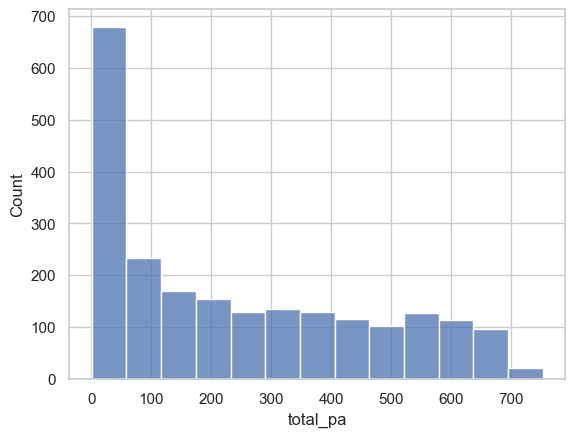

In [255]:
#plot of total plate appearances (min 1). Note this includes pitchers
df_players_with_pa = df_players_full[df_players_full['total_pa'] > 0] 
sns.histplot(df_players_with_pa['total_pa'])

<Axes: xlabel='total_bf', ylabel='Count'>

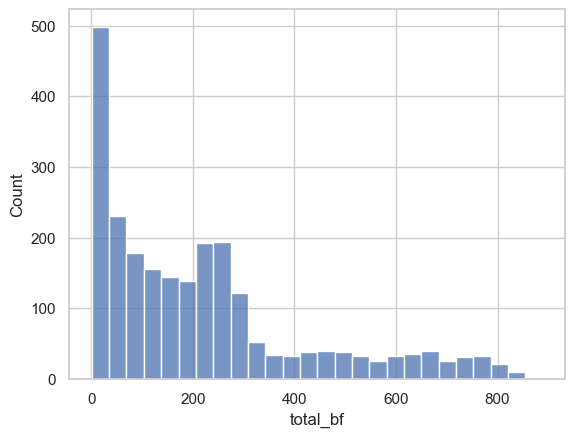

In [256]:
#plot of total batters faced (min 1). Note this includes position players
df_players_with_pa = df_players_full[df_players_full['total_bf'] > 0] 
sns.histplot(df_players_with_pa['total_bf'])

In [ ]:
def linear_regression_scatter(df, x, y, min_x=False, min_y=False):
    """
    This function filters out missing values and optionally removes entries that do not meet 
    specified minimum thresholds for the x and y variables. It then fits a simple linear 
    regression model, plots the data points, and overlays the regression line.

    Parameters:
    -----------
    df : pandas.DataFrame
        The dataset containing the variables to be plotted.
    x : str
        The column name representing the independent variable.
    y : str
        The column name representing the dependent variable.
    min_x : float or bool, optional (default=False)
        The minimum threshold for filtering x values. Entries with x < min_x will be removed.
    min_y : float or bool, optional (default=False)
        The minimum threshold for filtering y values. Entries with y < min_y will be removed.

    Returns: None
    """
    
    #filter entries to where columns aren't null
    df = df[df[x].notnull() & df[y].notnull()]

    #filter out player who do not meet the min
    if min_x != False:
        df = df[df[x] >= min_x]
    
    if min_y != False:
        df = df[df[y] >= min_y]
    
    #get passed columns 
    x_vals = df[x]
    y_vals = df[y]
    
    #perform linear regression
    slope, intercept, r, p, std_err = stats.linregress(x_vals, y_vals)
    
    #define regression function
    def myfunc(x_vals):
        return slope * x_vals + intercept
    
    #generate regression line values
    mymodel = list(map(myfunc, x_vals))
    
    #create scatter plot with regression line
    plt.figure(figsize=(10, 6))  # Increase figure size for better readability
    sns.set_theme(style="whitegrid")  # Use a clean theme
    
    #scatter plot
    sns.scatterplot(x=x_vals, y=y_vals, color="blue", alpha=0.6, s=60, label="Player Data")
    
    #regression line
    plt.plot(x_vals, mymodel, color="red", linewidth=2, label=f"Regression Line (a: {slope:.2f}, b: {intercept:.2f}, R²={r**2:.2f})")
    
    #add text and plot
    plt.title(f"Relationship Between {x} and {y}", fontsize=16)
    plt.xlabel(f"{x}", fontsize=14)
    plt.ylabel(f"{y}", fontsize=14)
    plt.legend(fontsize=12)
    plt.tight_layout()
    plt.show()

In [ ]:
df_players_full.head()

In [ ]:
linear_regression_scatter(df_players_full,'obp','total_pa')

In [ ]:
linear_regression_scatter(df_players_full,'ops','total_pa', min_y=100)

In [ ]:
#full list of all columns in df_players
for i in df_players_full.columns:
    print(i + ',')

IN PROGRESS: start looking at pitching information

In [ ]:
#see pitch run (is this right? Why do sliders have the least movement?)
counts = df_savant_raw.groupby(['pitcher','year','pitch_type'])[['release_speed']].count().reset_index()
df_players_full_merge = df_players_full.merge(counts, left_on=['player_mlb_id', 'year'], right_on=['pitcher', 'year'], how='left')

In [ ]:
df_players_full_merge.head()

In [ ]:
all_pitch_types = df_savant_raw['pitch_type'].dropna().unique()

In [ ]:
#for pitch in all_pitch_types:
    

In [ ]:
#find percent of each pitch thrown by each player
#get average x and z run of each pitch

In [ ]:
df_players_full[df_players_full['field_pct'].notna()]